In [6]:
#Imports 
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd # library for data analysis
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
# Parse Wikipedia pages for top singls 
url_base = "https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_"
years = range(1959,2021)
d = {'No.': pd.Series(dtype='int'), 
        'Title': pd.Series(dtype='str'), 
        'Artist(s)': pd.Series(dtype='str'), 
        'year': pd.Series(dtype='str')}
df = pd.DataFrame(d)        
for y in years:
    print(y)
    wikiurl=url_base + str(y)
    table_class="wikitable sortable jquery-tablesorter"
    response=requests.get(wikiurl)
    if response.status_code != 200:
        print("error!!  " + str(response.status_code))
    # parse data from the html into a beautifulsoup object
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table',{'class':"wikitable"})
    temp_df = pd.DataFrame(pd.read_html(str(table))[0])
    if temp_df.columns[0] == '№':
        temp_df = temp_df.rename(columns = {'№':'No.'})
    #convert list to dataframe
    temp_df['year'] = y
    df = pd.concat([df,temp_df], ignore_index=True)
df['popularity'] = -1 ## set default popularity default to be -1
temp_df = df.copy()

1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [9]:
# cid = your Spotify API cid
# secret = your Spotify API secret
# needed to do some hacks here to remove stuff spotify API search doesn't like, such as "and", "featuring", "&". 
# note that still around 10% of the songs could not be found in search. Manual analysis showed that these are uniformly 
# distributed across years and across index in top 100 lists so shouldn't affect results 
for index, row in df.iterrows():
    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
    spotify = spotipy.Spotify(client_credentials_manager = client_credentials_manager)        
    title = row['Title'].split('/',1)[0].replace('"', '')
    artist = row['Artist(s)']
    artist = artist.replace('The ', '').replace('and ', "").replace('featuring ', "").replace('& ', "")
    search = 'artist:' + artist + " track:" + title
    try:
        results = spotify.search(q=search, type='track', limit=50)
    except Exception as e:
        print("exception occured" + str(e) + " for " + search)
        continue
    if index % 50 == 0:
        print(index)
    if results is None or results['tracks'] is None or results['tracks']['items'] is None:
        print("couldn't get results for " + search)
        continue
    if len(results['tracks']['items']) > 0:
        try : 
            # take the result with the highest popularity 
            df.at[index, 'popularity'] = max([d['popularity'] for d in results['tracks']['items']])        
        except Exception as e:
            continue

df = df[df['No.'] != 'Tie'] #remove one song that is "Tied"
df.to_csv('songs_with_popularity.csv')
filtered_df = df[df['popularity']!=-1]
filtered_df = filtered_df[~filtered_df['popularity'].isnull()]
print("length of df %s length of filtered df %s", (len(df), len(filtered_df)))
filtered_df.to_csv("songs_with_popularity_filtered.csv")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
length of df %s length of filtered df %s (6201, 5732)


/var/folders/_x/4zc80d_97b972xrz5pkc1j0w0000gn/T/ipykernel_63839/496202860.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df.groupby('year').median()


<Figure size 1500x500 with 0 Axes>

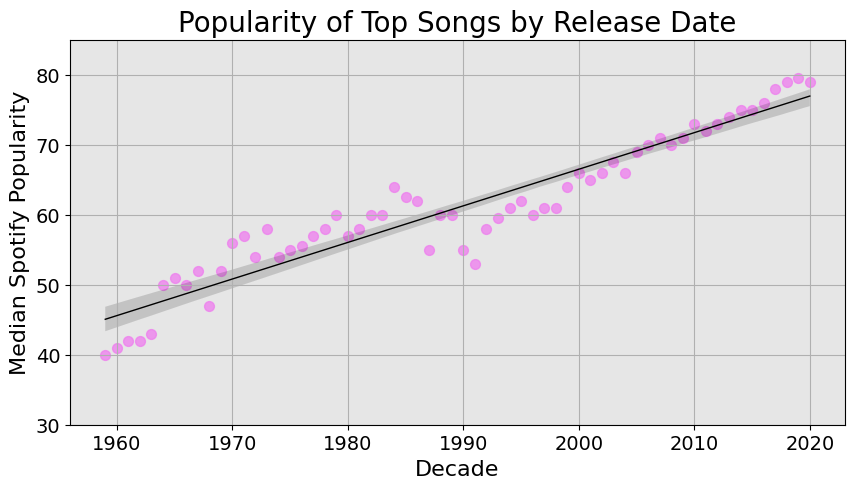

In [50]:
df = pd.read_csv('songs_with_popularity_filtered.csv')
df['No.'] = df['No.'].astype(int)
df = df[df['No.'] <= 50] # filter out the top X singles per year if you wish
fig = plt.figure(figsize = (15, 5))
df['decade'] = (df['year'] - df['year'] % 10) 
fig = plt.figure(figsize = (10, 5))
grouped = df.groupby('year').median() 
ax = sns.regplot(x=grouped.index, y=grouped['popularity'], line_kws={'linewidth':1, "color":'black'},
    scatter_kws={'color':'violet', 's':50})
ax.set(ylim=[30,85])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.grid()
plt.gca().patch.set_facecolor('0.9')
plt.ylabel('Median Spotify Popularity', fontsize=16)
plt.xlabel('Decade', fontsize=16)
plt.title('Popularity of Top Songs by Release Date', fontsize = 20)
linear_equation = np.poly1d(np.polyfit(grouped.index, grouped.popularity, 1))

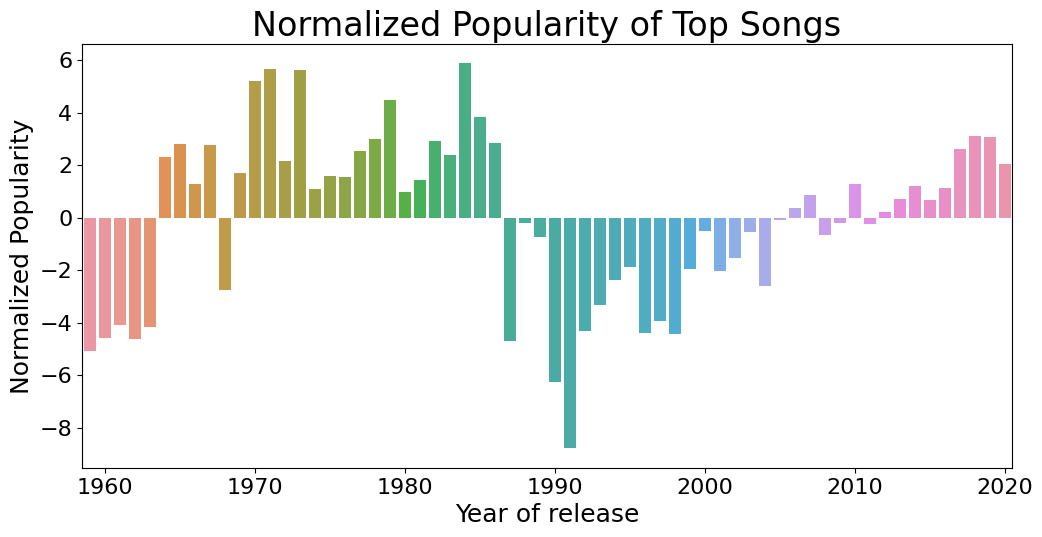

In [73]:
#normalize by trend line 
fig = plt.figure(figsize = (12, 5.5))
grouped['normalized_popularity'] = grouped['popularity'] - linear_equation(grouped.index)
ax = sns.barplot(data = grouped, x = grouped.index, y = 'normalized_popularity')
plt.xticks(np.arange(1,len(ax.get_xticklabels())+1,10), fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Normalized Popularity', fontsize = 18)
plt.xlabel('Year of release', fontsize = 18)
plt.title('Normalized Popularity of Top Songs', fontsize = 24)
plt.savefig("normalized_popularity")


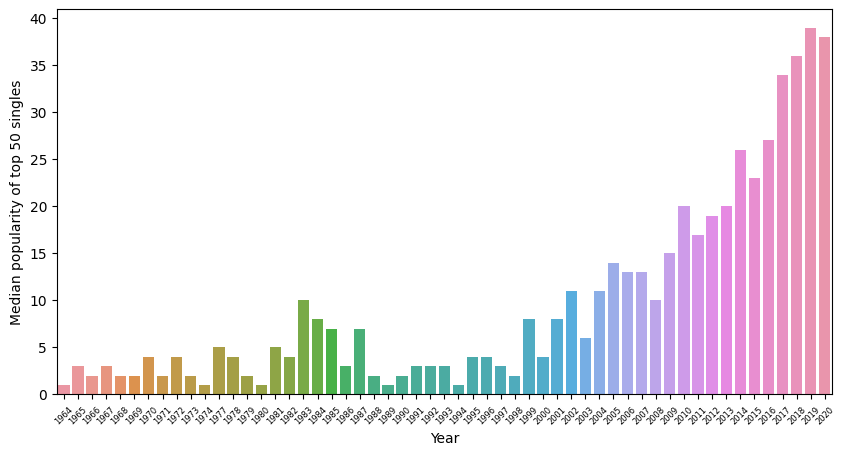

In [145]:
# other way around - from most popular song relative to release date
# df2000 = pd.read_csv('Spotify-2000.csv') shitty dataset i don't buy it
df_top = df[df['popularity'] >=75]
grouped = df_top.groupby('year').count()
fig = plt.figure(figsize = (10, 5))
ax = sns.barplot(x=grouped.index, y=grouped.popularity)
ax.set(xlabel = 'Year', ylabel = 'Median popularity of top 50 singles')
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=6)
df_top.to_csv('over_75_popularity.csv')